#  ATOC5860 Application Lab #5 - ENSO_butterworth
##### Written by Prof. Kay (CU) and Prof. Maroon (formerly CU, now U-Wisconsin)
##### last updated March 13, 2024 - works with environment atoc5860env2024


### LEARNING GOALS:
1) Assess the influence of filtering on data in both the time domain (i.e., in time series plots) and the spectral domain (i.e., in plots of the power spectra).
2) Apply a Butterworth filter to remove power of specific frequencies from a time series.
3) Contrast the influence of differing window weights on the filtered dataset both in the time domain and the spectral domain. 
4) Calculate the response function using the Convolution Theorem.
5) Assess why the python function filtfilt is filtering twice.


### DATA and UNDERLYING SCIENCE MOTIVATION:  

Data are monthly Nino3.4 sea surface temperature (SST) time series (a proxy for ENSO) from the
CESM1 Large Ensemble (doi: 10.1175/BAMS-D-13-00255.1, http://www.cesm.ucar.edu/projects/community-projects/LENS/). 
You will analyze pre-industrial control runs that represent perpetual 1850 conditions  (i.e., they have constant 1850 climate). Data are munged (preprocessed) by the NCAR CVDP package (doi: 10.1002/2014EO490002, http://www2.cesm.ucar.edu/working_groups/CVC/cvdp//data-repository.html). Note: these are the same data from Homework 4 :) Remember??? 

**Questions to guide your analysis** 

1) Look at your data!  Read in your data. Make a plot of your data.  Make sure your data are anomalies (i.e., the mean has been removed).  Look at your data again!  Do you see variance at frequencies that you might be able to remove? 

2) Calculate the power spectrum of your original data. Calculate the power spectra of the Nino3.4 SST index (variable called “nino34”) in the fully coupled model 1850 control run.  Apply the analysis to the first 700 years of the run. Use Welch’s method (WOSA!) with a Hanning window and a window length of 50 years. Make a plot of normalized spectral power vs. frequency.  Where is their power that you might be able to remove with filtering?

3) Apply a Butterworth Filter. Use a Butterworth filter to remove all spectral power at frequencies greater than 0.04 per month (i.e., less than 2 year). Use an order 1 Butterworth filter (N=1, 1 weight).  Replot the original data and the filtered data. Calculate the power spectra of your filtered data.  Assess the influence of your filtering in both in time domain (i.e., by comparing the original data time series and filtered time series data) and the frequency domain (i.e., by comparing the power spectrum of the original data and the power spectrum of the filtered data).  Look at the response function of the filter in spectral domain using the convolution theorem. Well that was pretty boring… we still have most of the power retained….

4) Let’s apply another Butterworth Filter and this time really get rid of ENSO power!. Let’s really have some fun with the Butterworth filter and have a big impact on our data...  Let’s remove ENSO variability from our original timeseries.  Apply the Butterworth filter but this time change the frequency that you are cutting off to 0.01 per month (i.e., remove all power with timescales less than 8 years).  Use an order 1 filter (N=1). Replot the original data and the filtered data. Calculate the power spectra of your filtered data. Assess the influence of your filtering in both in time domain (i.e., by comparing the original data time series and filtered time series data) and the frequency domain (i.e., by comparing the power spectrum of the original data and the power spectrum of the filtered data). Look at the response function of the filter in spectral domain using the convolution theorem.

5) Let’s apply yet another Butterworth Filter – and this time one with more weights. Repeat step 4) but this time change the order of the filter.  In other words, increase the number of weights being used in the filter by increasing the parameter N in the jupyter notebook.  What is the impact of increasing N on the filtered dataset, the power spectra, and the moving window weights?  You should see that as you increase N – a sharper cutoff in frequency space occurs in the power spectra.  Why?   At some point, butterworth goes crazy, giving you a response function that is greater than 1.  Why is that a problem?

6) Assess what is “under the hood” of the python function.  How are the edge effects treated?  Why is the function filtfilt filtering twice?

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import scipy.signal as sig
from matplotlib.gridspec import GridSpec
import timeit
import scipy.io as sio
import xarray
import pickle

In [2]:
## Read in the data.
fname1="CESM1_LENS_Coupled_Control.cvdp_data.401-2200.nc"
ds1=xarray.open_dataset(fname1,decode_times=False,decode_cf=False)
#ds1
data_fc=ds1["nino34"]
#print(data_fc)
nyrs=700
x=data_fc[0:12*nyrs]
    
## remove the mean (i.e., calculate the anomaly)
xa = x - np.mean(x)  

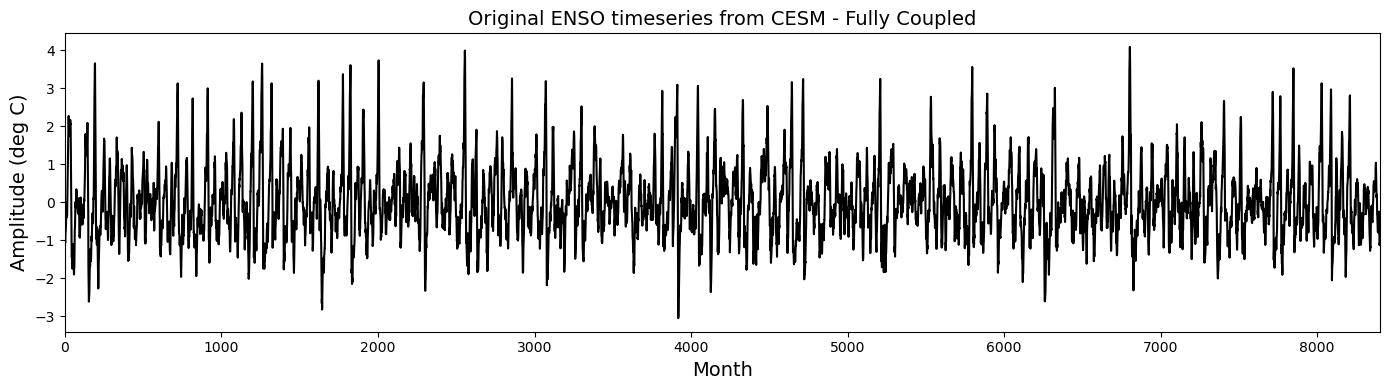

In [3]:
## Look at your data!!!
var_str = "Monthly Nino34 Anomaly"
data_units = "deg C"
f=plt.figure(figsize=(14,4))
plt.plot(x,'-k',linewidth = 1.5, label = 'raw input');
plt.xlim(-1,np.size(x)+1);
plt.title('Original ENSO timeseries from CESM - Fully Coupled',fontsize=14);
plt.xlabel('Month',fontsize=14);
plt.ylabel('Amplitude (' + data_units + ')',fontsize=14);
f.tight_layout()

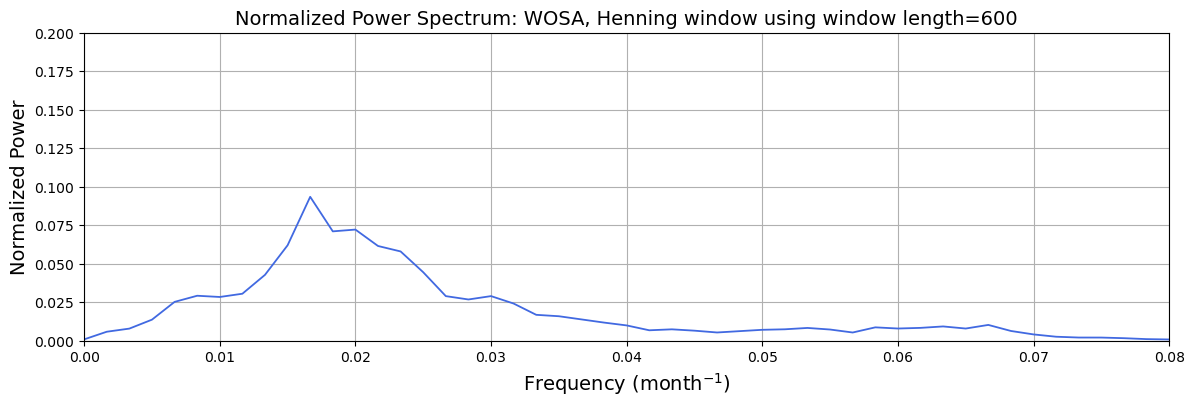

In [5]:
### Calculate the power spectrum of the original data
data=xa

## Use the Hanning Window and WOSA (Welch’s Overlapping Segment Analysis)
nyrs=50
window_length=12*nyrs
freq_w = np.arange(0.,(window_length/2)+1.)/window_length
P_welch = sig.welch(data,window='hamming',nperseg=window_length);
P_welch_n = P_welch[1]/np.sum(P_welch[1])  #normalize

## plot
fig = plt.figure(figsize=(14,4))
plt.xlabel('Frequency (month$^{-1}$)',fontsize=14)
plt.ylabel('Normalized Power',fontsize=14)
plt.ylim(0.0,0.20)
plt.xlim(0.0,0.08)  
plt.grid()
plt.plot(freq_w,P_welch_n, color='royalblue', lw=1.3, label='Hanning,wl='+str(window_length));
plt.title("Normalized Power Spectrum: WOSA, Henning window using window length="+str(window_length),fontsize=14);

frequency_cutoff: 0.04
frequency_cutoff_in_years: 2.0833333333333335


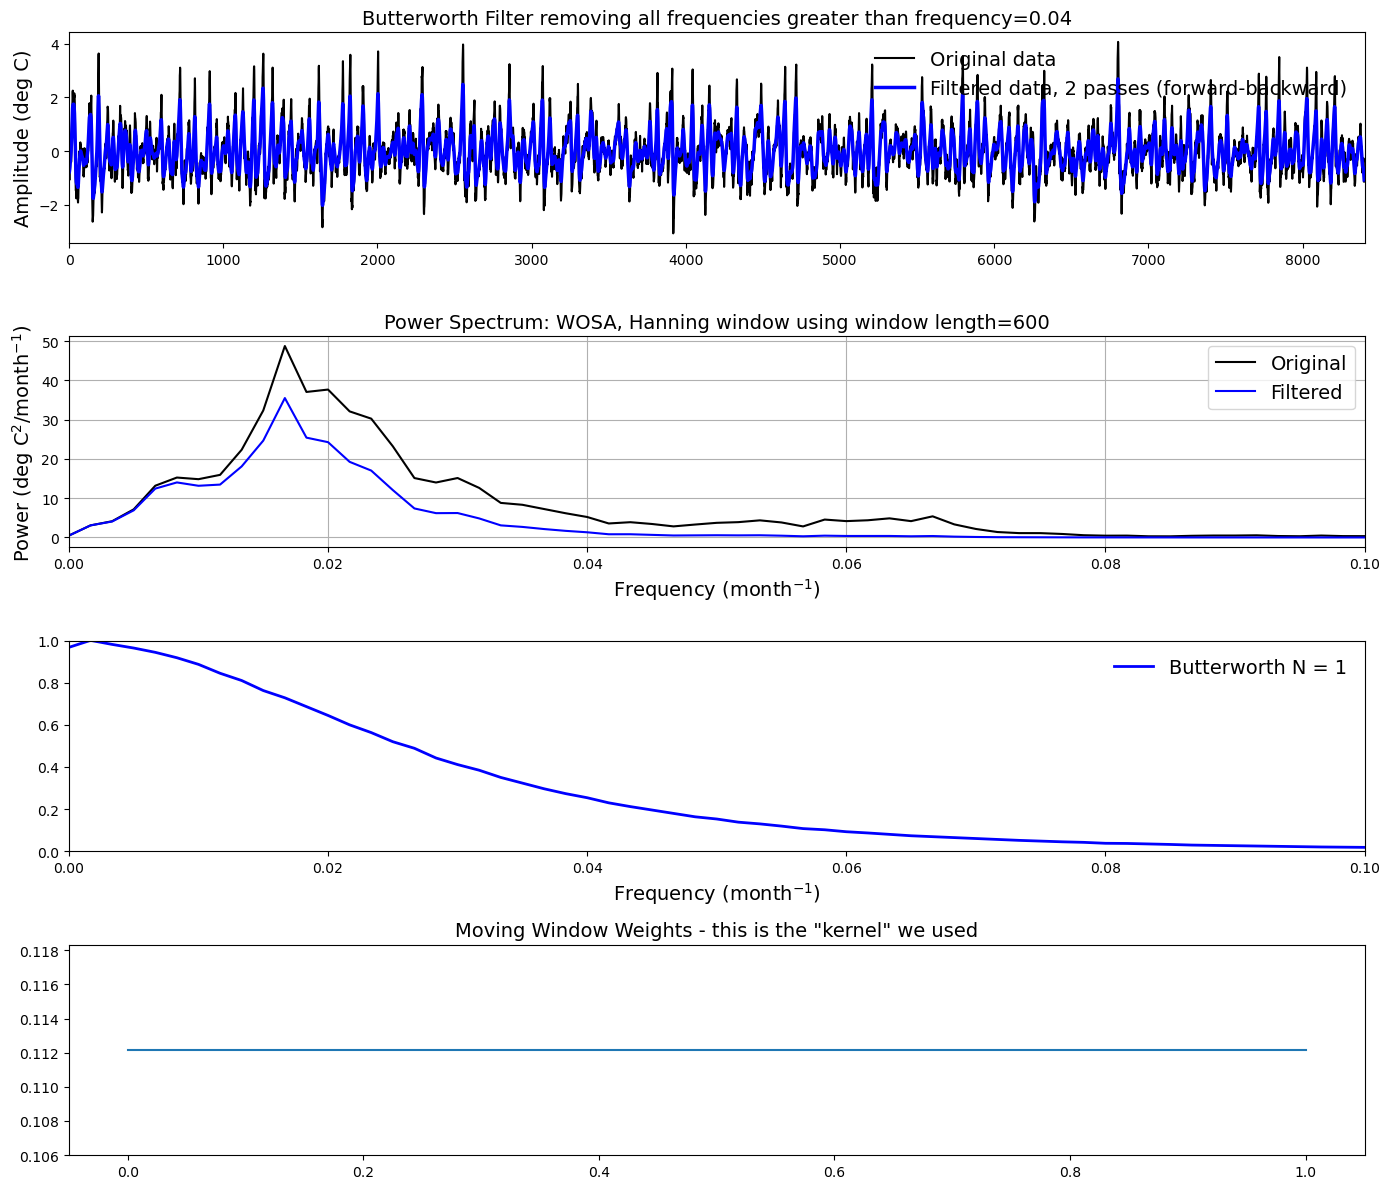

In [10]:
### Let's have some fun with the Butterworth filter (aka mrsbutterworth)
### We'll remove all frequencies greater than 0.04 (i.e., all periods shorter than 2 years).  
### We should expect the impact of this filtering to be pretty boring as there isn't a 
### lot of spectral power at high frequencies (frequencies higher than 0.04).

frequency_cutoff=0.04
frequency_cutoff_in_years=1/(frequency_cutoff*12)
print("frequency_cutoff: "+str(frequency_cutoff))
print("frequency_cutoff_in_years: "+str(frequency_cutoff_in_years))

### Apply a Butterworth filter (recursive filter) to the data
N = 1 ## order
Wn = frequency_cutoff*2 ## scalar given the critical frequency (all higher frequencies are removed)
## Note: Wn is normalized from 0 to 1, where 1 is the Nyquist frequency, pi radians/sample. 
## Note: (Wn is thus in half-cycles / sample.) 
b, a = sig.butter(N, Wn)
y = sig.filtfilt(b,a,xa) ## one filter forward, one filter backward - you are filtering twice

### Calculate the power spectra - Hanning Window and WOSA (Welch’s Overlapping Segment Analysis)
data=y
P_welch_filt = sig.welch(data,window='hamming',nperseg=window_length);
P_welch_n_filt = P_welch[1]/np.sum(P_welch[1])  #normalize

### Calculate the response function of the butterworth filter using the convolution theorem
R2_bw=P_welch_filt[1]/P_welch[1]

## plot
gs=GridSpec(4,1)
f=plt.figure(figsize=(14,12))
fig=plt.subplot(gs[0,0])
plt.plot(xa,'-k',linewidth = 1.5, label = 'Original data');
plt.plot(y,'-b',linewidth = 2.5, label = 'Filtered data, 2 passes (forward-backward)');
plt.title('Butterworth Filter removing all frequencies greater than frequency='+str(frequency_cutoff),fontsize=14)
plt.legend(frameon = False,fontsize = 14,loc='upper right')
plt.ylabel('Amplitude (' + data_units + ')',fontsize=14);
plt.xlim(-1,np.size(x)+1)

fig=plt.subplot(gs[1,0])
plt.xlabel('Frequency (month$^{-1}$)',fontsize=14)
plt.ylabel('Power (deg C$^2$/month$^{-1}$)',fontsize=14)
#plt.ylim(0.0,0.40)
plt.xlim(0.0,0.10)  
plt.grid()
plt.plot(freq_w,P_welch[1],'-k',lw=1.5, label='Original');
plt.plot(freq_w,P_welch_filt[1],'-b',lw=1.5, label='Filtered');
plt.legend(loc='upper right',fontsize=14)
plt.title("Power Spectrum: WOSA, Hanning window using window length="+str(window_length),fontsize=14);

fig=plt.subplot(gs[2,0])
plt.plot(freq_w,R2_bw,'-b',linewidth = 2, label = 'Butterworth N = '+str(N));
plt.xlabel('Frequency (month$^{-1}$)',fontsize=14);
# plt.ylabel('|{R$^2}$| response function' ,fontsize=14);
plt.legend(fontsize = 14, frameon = False);
plt.ylim(0.0,1.0);
plt.xlim(0.0,0.10); 

fig=plt.subplot(gs[3,0])
plt.plot(b);
plt.title('Moving Window Weights - this is the "kernel" we used',fontsize=14)
f.tight_layout()

In [11]:
## Let's have some MORE fun with mrbutterworth.  We'll now remove ENSO and any sub-decadal variability
##i.e., let's remove all frequencies greater than 0.01 (shorter than 8 years)
frequency_cutoff=0.01
frequency_cutoff_in_years=1/(frequency_cutoff*12)
print("frequency_cutoff: "+str(frequency_cutoff))
print("frequency_cutoff_in_years: "+str(frequency_cutoff_in_years))

### Apply a Butterworth filter (recursive filter) to the data
N = 1 ## order
Wn = frequency_cutoff*2 ## scalar given the critical frequency (all higher frequencies are removed)
## Note: Wn is normalized from 0 to 1, where 1 is the Nyquist frequency, pi radians/sample. 
## Note: (Wn is thus in half-cycles / sample.) 
b, a = sig.butter(N, Wn)
y = sig.filtfilt(b,a,xa) ## one filter forward, one filter backward - you are filtering twice

### Calculate the power spectra - Hanning Window and WOSA (Welch’s Overlapping Segment Analysis)
data=y
P_welch_filt = sig.welch(data,window='hamming',nperseg=window_length);
P_welch_n_filt = P_welch[1]/np.sum(P_welch[1])  #normalize

### Calculate the response function of the butterworth filter using the convolution theorem
R2_bw=P_welch_filt[1]/P_welch[1]

## plot
gs=GridSpec(4,1)
f=plt.figure(figsize=(14,12))
fig=plt.subplot(gs[0,0])
plt.plot(xa,'-k',linewidth = 1.5, label = 'Original data');
plt.plot(y,'-b',linewidth = 2.5, label = 'Filtered data, 2 passes (forward-backward)');
plt.title('Butterworth Filter removing all frequencies greater than frequency='+str(frequency_cutoff),fontsize=14)
plt.legend(frameon = False,fontsize = 14,loc='upper right')
plt.ylabel('Amplitude (' + data_units + ')',fontsize=14);
plt.xlim(-1,np.size(x)+1)

fig=plt.subplot(gs[1,0])
plt.xlabel('Frequency (month$^{-1}$)',fontsize=14)
plt.ylabel('Power (deg C$^2$/month$^{-1}$)',fontsize=14)
#plt.ylim(0.0,0.40)
plt.xlim(0.0,0.10)  
plt.grid()
plt.plot(freq_w,P_welch[1],'-k',lw=1.5, label='Original');
plt.plot(freq_w,P_welch_filt[1],'-b',lw=1.5, label='Filtered');
plt.legend(loc='upper right')
plt.title("Normalized Power Spectrum: WOSA, Hanning window using window length="+str(window_length),fontsize=14);

fig=plt.subplot(gs[2,0])
plt.plot(freq_w,R2_bw,'-b',linewidth = 2, label = 'Butterworth N = '+str(N));
plt.xlabel('Frequency (month$^{-1}$)',fontsize=14);
plt.ylabel('|R$^2}$| response function' ,fontsize=14);
plt.legend(fontsize = 14, frameon = False);
plt.ylim(0.0,1.0);
plt.xlim(0.0,0.10); 

fig=plt.subplot(gs[3,0])
plt.plot(b);
plt.title('Moving Window Weights - this is the "kernel" we used',fontsize=14)
f.tight_layout()

frequency_cutoff: 0.01
frequency_cutoff_in_years: 8.333333333333334


ValueError: 
|R$^2}$| response function
  ^
ParseException: Expected end of text, found '$'  (at char 2), (line:1, col:3)

Error in callback <function _draw_all_if_interactive at 0x12f86b920> (for post_execute), with arguments args (),kwargs {}:


ValueError: 
|R$^2}$| response function
  ^
ParseException: Expected end of text, found '$'  (at char 2), (line:1, col:3)

ValueError: 
|R$^2}$| response function
  ^
ParseException: Expected end of text, found '$'  (at char 2), (line:1, col:3)

<Figure size 1400x1200 with 4 Axes>

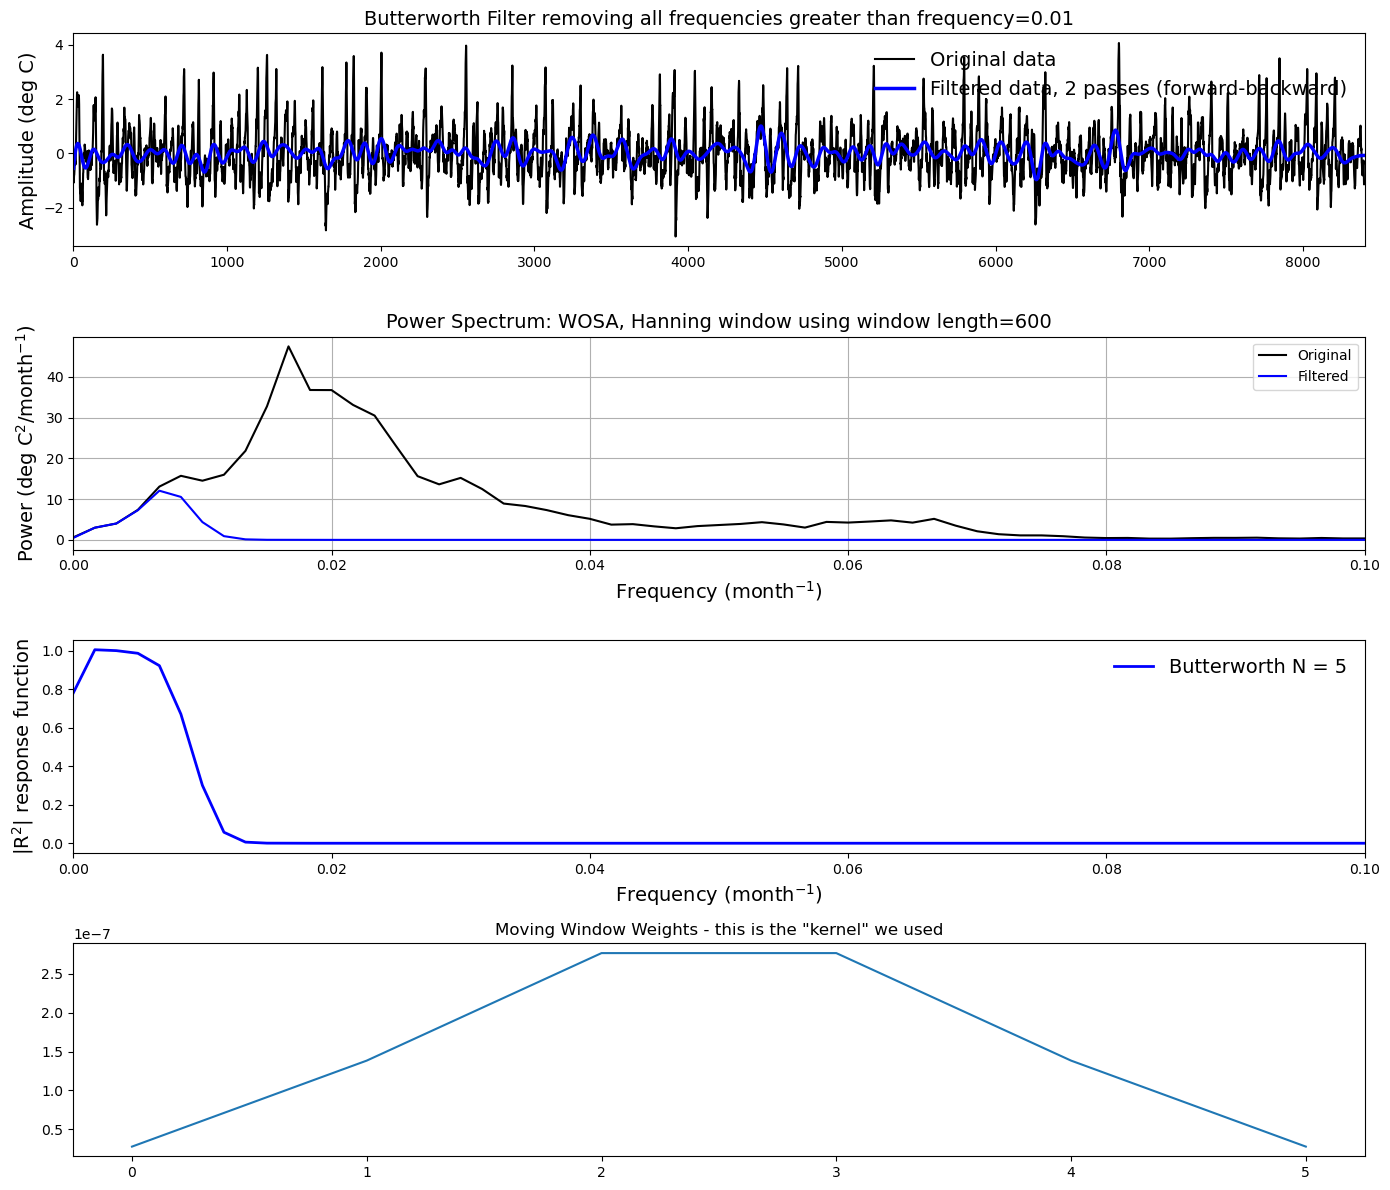

In [7]:
### Let's have some MORE fun with mrbutterworth. 
## Let's remove ENSO again but increase the number of weights in the Butterworth Filter
## Note: We should expect the cutoff in frequency space to be steeper when we use a 
## higher order Butterworth Filter (i.e., when we increase N)

### Apply a Butterworth filter (recursive filter) to the data
N = 5 ## order
Wn = frequency_cutoff*2 ## scalar given the critical frequency (all higher frequencies are removed)
## Note: Wn is normalized from 0 to 1, where 1 is the Nyquist frequency, pi radians/sample. 
## Note: (Wn is thus in half-cycles / sample.) 
b, a = sig.butter(N, Wn)
y = sig.filtfilt(b,a,xa) ## one filter forward, one filter backward - you are filtering twice

### Calculate the power spectra - Hanning Window and WOSA (Welch’s Overlapping Segment Analysis)
data=y
P_welch_filt = sig.welch(data,window='hanning',nperseg=window_length);
P_welch_n_filt = P_welch[1]/np.sum(P_welch[1])  #normalize

### Calculate the response function of the butterworth filter using the convolution theorem
R2_bw=P_welch_filt[1]/P_welch[1]

## plot
gs=GridSpec(4,1)
f=plt.figure(figsize=(14,12))
fig=plt.subplot(gs[0,0])
plt.plot(xa,'-k',linewidth = 1.5, label = 'Original data');
plt.plot(y,'-b',linewidth = 2.5, label = 'Filtered data, 2 passes (forward-backward)');
plt.title('Butterworth Filter removing all frequencies greater than frequency='+str(frequency_cutoff),fontsize=14)
plt.legend(frameon = False,fontsize = 14,loc='upper right')
plt.ylabel('Amplitude (' + data_units + ')',fontsize=14);
plt.xlim(-1,np.size(x)+1)

fig=plt.subplot(gs[1,0])
plt.xlabel('Frequency (month$^{-1}$)',fontsize=14)
plt.ylabel('Power (deg C$^2$/month$^{-1}$)',fontsize=14)
#plt.ylim(0.0,0.40)
plt.xlim(0.0,0.10)  
plt.grid()
plt.plot(freq_w,P_welch[1],'-k',lw=1.5, label='Original');
plt.plot(freq_w,P_welch_filt[1],'-b',lw=1.5, label='Filtered');
plt.legend(loc='upper right')
plt.title("Power Spectrum: WOSA, Hanning window using window length="+str(window_length),fontsize=14);

fig=plt.subplot(gs[2,0])
plt.plot(freq_w,R2_bw,'-b',linewidth = 2, label = 'Butterworth N = '+str(N));
plt.xlabel('Frequency (month$^{-1}$)',fontsize=14)
plt.ylabel('|R$^2}$| response function' ,fontsize=14);
plt.legend(fontsize = 14, frameon = False);
#plt.ylim(0.0,1.0);
plt.xlim(0.0,0.10); 

fig=plt.subplot(gs[3,0])
plt.plot(b);
plt.title('Moving Window Weights - this is the "kernel" we used')
f.tight_layout()

frequency_cutoff: 0.08
frequency_cutoff_in_years: 1.0416666666666667


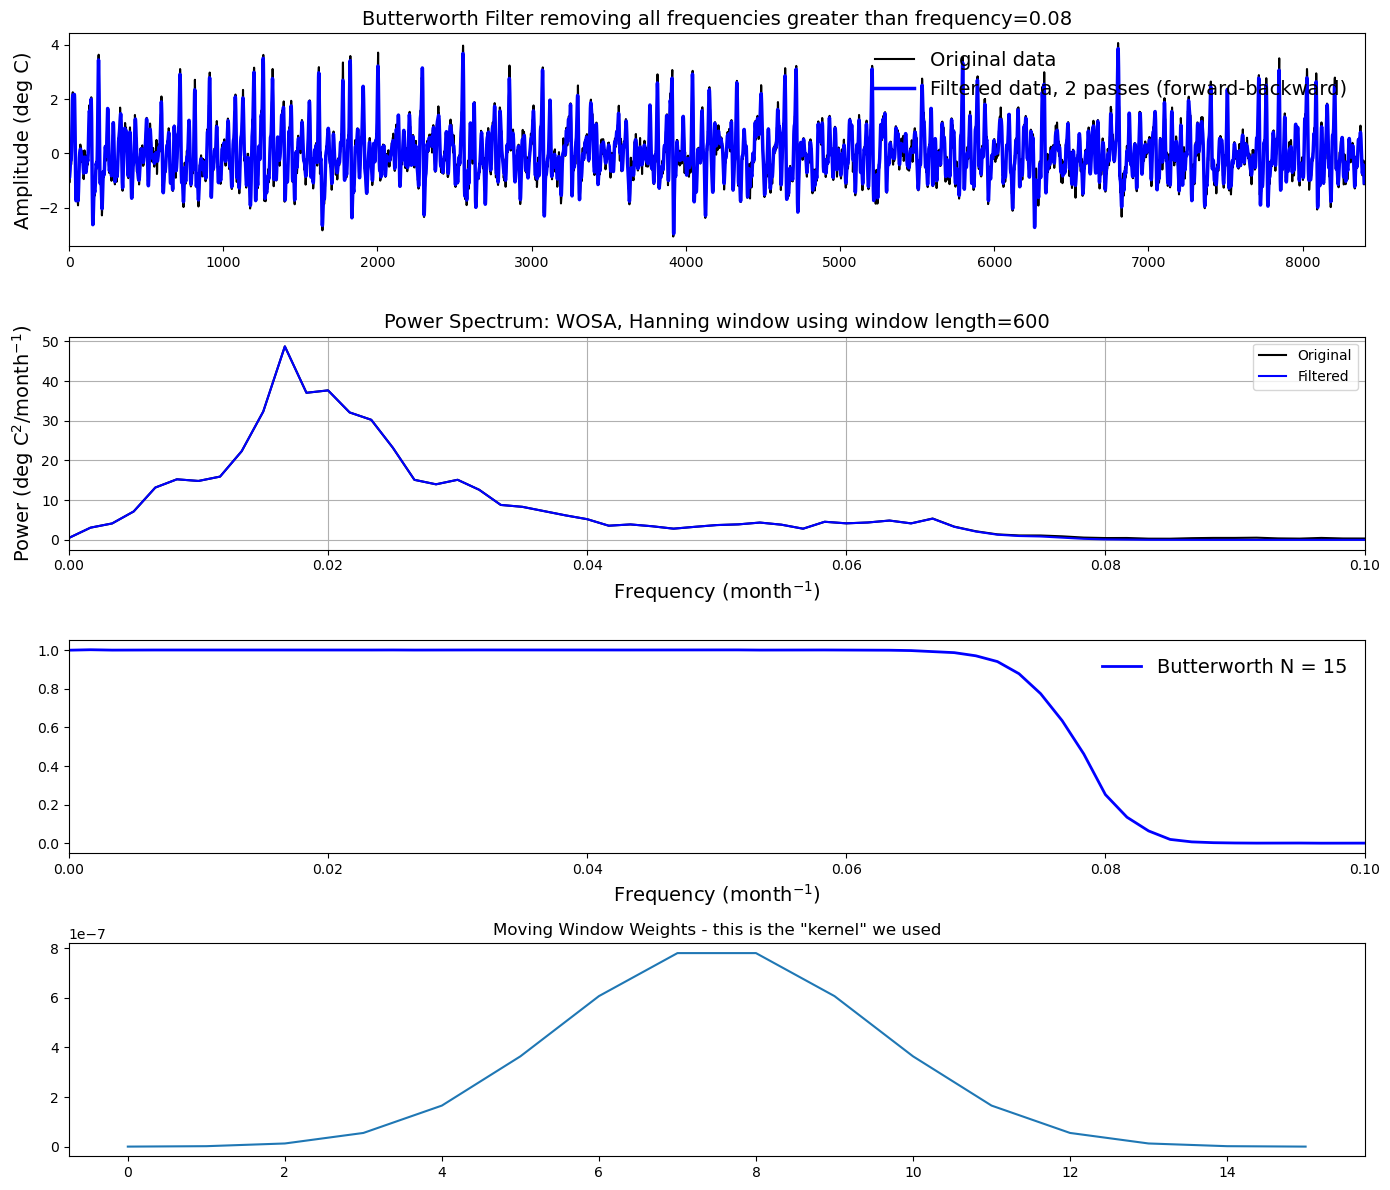

In [20]:
### Here's an example where we are starting to see the influence of the impulse function on the 
### low frequencies of the filtered dataset... ### You can only have so much tangency....

frequency_cutoff=0.08
frequency_cutoff_in_years=1/(frequency_cutoff*12)
print("frequency_cutoff: "+str(frequency_cutoff))
print("frequency_cutoff_in_years: "+str(frequency_cutoff_in_years))

### Apply a Butterworth filter (recursive filter) to the data
N = 15 ## order
Wn = frequency_cutoff*2 ## scalar given the critical frequency (all higher frequencies are removed)
## Note: Wn is normalized from 0 to 1, where 1 is the Nyquist frequency, pi radians/sample. 
## Note: (Wn is thus in half-cycles / sample.) 
b, a = sig.butter(N, Wn)
y = sig.filtfilt(b,a,xa) ## one filter forward, one filter backward - you are filtering twice

### Calculate the power spectra - Hanning Window and WOSA (Welch’s Overlapping Segment Analysis)
data=y
P_welch_filt = sig.welch(data,window='hamming',nperseg=window_length);
P_welch_n_filt = P_welch[1]/np.sum(P_welch[1])  #normalize

### Calculate the response function of the butterworth filter using the convolution theorem
R2_bw=P_welch_filt[1]/P_welch[1]

## plot
gs=GridSpec(4,1)
f=plt.figure(figsize=(14,12))
fig=plt.subplot(gs[0,0])
plt.plot(xa,'-k',linewidth = 1.5, label = 'Original data');
plt.plot(y,'-b',linewidth = 2.5, label = 'Filtered data, 2 passes (forward-backward)');
plt.title('Butterworth Filter removing all frequencies greater than frequency='+str(frequency_cutoff),fontsize=14)
plt.legend(frameon = False,fontsize = 14,loc='upper right')
plt.ylabel('Amplitude (' + data_units + ')',fontsize=14);
plt.xlim(-1,np.size(x)+1)

fig=plt.subplot(gs[1,0])
plt.xlabel('Frequency (month$^{-1}$)',fontsize=14)
plt.ylabel('Power (deg C$^2$/month$^{-1}$)',fontsize=14)
#plt.ylim(0.0,0.40)
plt.xlim(0.0,0.10)  
plt.grid()
plt.plot(freq_w,P_welch[1],'-k',lw=1.5, label='Original');
plt.plot(freq_w,P_welch_filt[1],'-b',lw=1.5, label='Filtered');
plt.legend(loc='upper right')
plt.title("Power Spectrum: WOSA, Hanning window using window length="+str(window_length),fontsize=14);

fig=plt.subplot(gs[2,0])
plt.plot(freq_w,R2_bw,'-b',linewidth = 2, label = 'Butterworth N = '+str(N));
plt.xlabel('Frequency (month$^{-1}$)',fontsize=14)
# plt.ylabel('|R$^2}$c| response function' ,fontsize=14);
plt.legend(fontsize = 14, frameon = False);
#plt.ylim(0.0,1.3);
plt.xlim(0.0,0.10); 

fig=plt.subplot(gs[3,0])
plt.plot(b);
plt.title('Moving Window Weights - this is the "kernel" we used')
f.tight_layout()

frequency_cutoff: 0.01
frequency_cutoff_in_years: 8.333333333333334


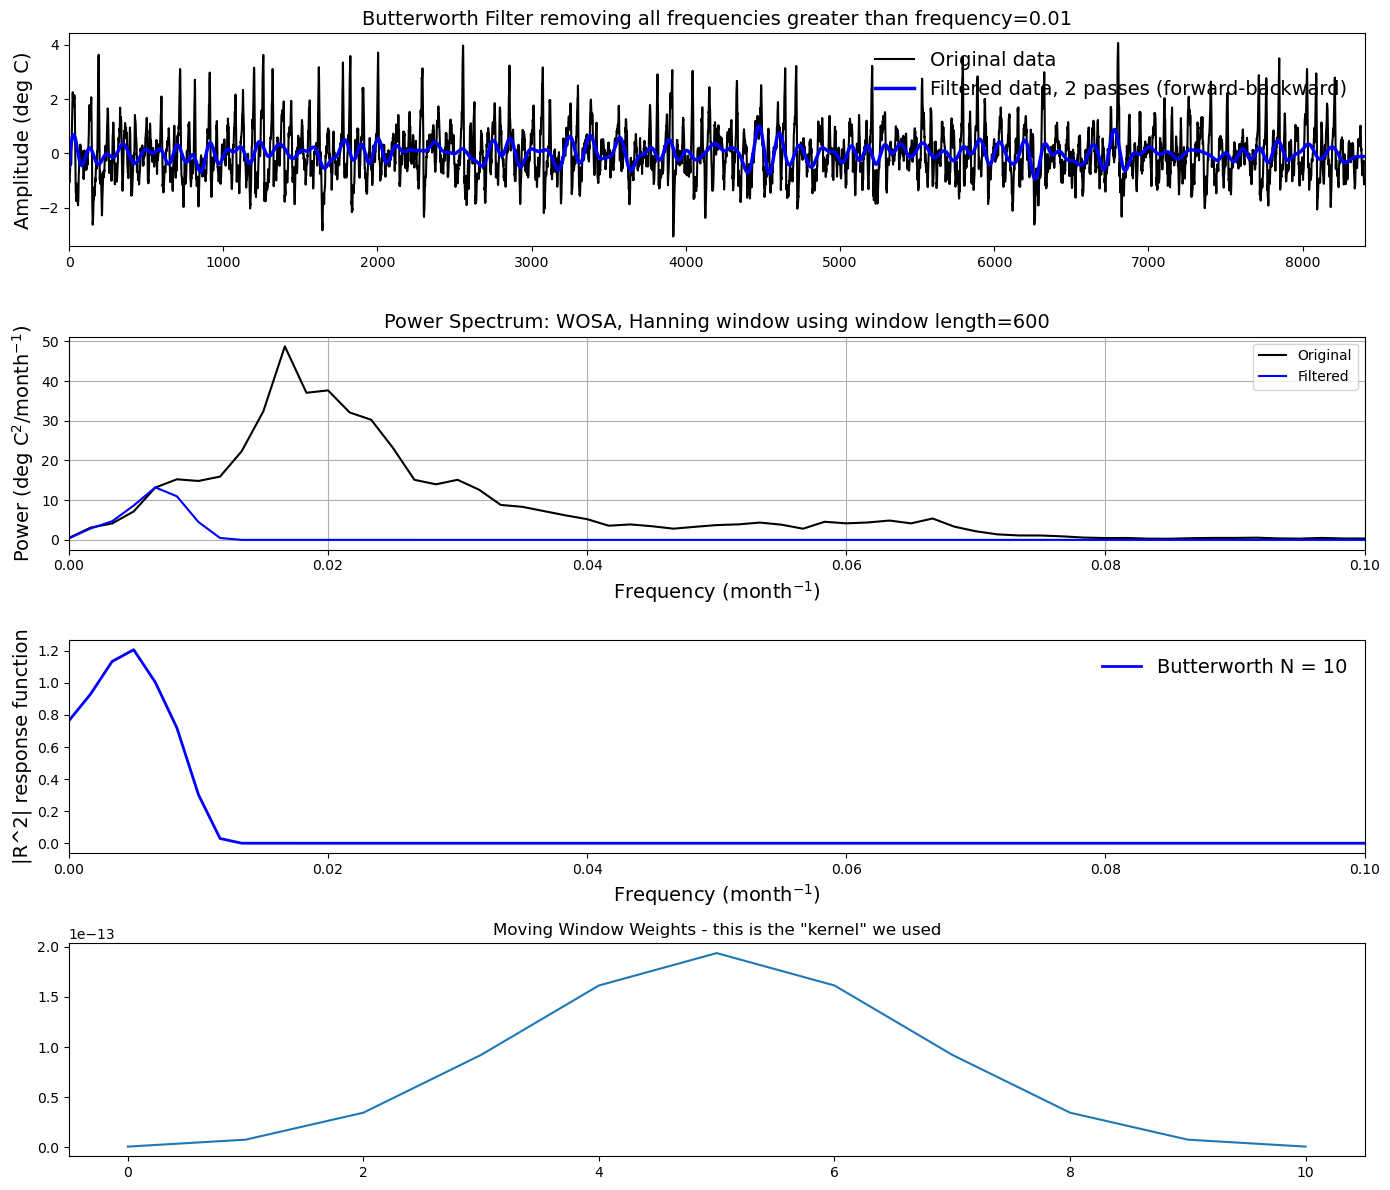

In [35]:
### Now with N=27 butterworth goes crazy...

frequency_cutoff=0.01
frequency_cutoff_in_years=1/(frequency_cutoff*12)
print("frequency_cutoff: "+str(frequency_cutoff))
print("frequency_cutoff_in_years: "+str(frequency_cutoff_in_years))

### Apply a Butterworth filter (recursive filter) to the data
N = 10 ## order, try 27!!
Wn = frequency_cutoff*2 ## scalar given the critical frequency (all higher frequencies are removed)
## Note: Wn is normalized from 0 to 1, where 1 is the Nyquist frequency, pi radians/sample. 
## Note: (Wn is thus in half-cycles / sample.) 
b, a = sig.butter(N, Wn)
y = sig.filtfilt(b,a,xa) ## one filter forward, one filter backward - you are filtering twice

### Calculate the power spectra - Hanning Window and WOSA (Welch’s Overlapping Segment Analysis)
data=y
P_welch_filt = sig.welch(data,window='hamming',nperseg=window_length);
P_welch_n_filt = P_welch[1]/np.sum(P_welch[1])  #normalize

### Calculate the response function of the butterworth filter using the convolution theorem
R2_bw=P_welch_filt[1]/P_welch[1]

## plot
gs=GridSpec(4,1)
f=plt.figure(figsize=(14,12))
fig=plt.subplot(gs[0,0])
plt.plot(xa,'-k',linewidth = 1.5, label = 'Original data');
plt.plot(y,'-b',linewidth = 2.5, label = 'Filtered data, 2 passes (forward-backward)');
plt.title('Butterworth Filter removing all frequencies greater than frequency='+str(frequency_cutoff),fontsize=14)
plt.legend(frameon = False,fontsize = 14,loc='upper right')
plt.ylabel('Amplitude (' + data_units + ')',fontsize=14);
plt.xlim(-1,np.size(x)+1)

fig=plt.subplot(gs[1,0])
plt.xlabel('Frequency (month$^{-1}$)',fontsize=14)
plt.ylabel('Power (deg C$^2$/month$^{-1}$)',fontsize=14)
#plt.ylim(0.0,0.40)
plt.xlim(0.0,0.10)  
plt.grid()
plt.plot(freq_w,P_welch[1],'-k',lw=1.5, label='Original');
plt.plot(freq_w,P_welch_filt[1],'-b',lw=1.5, label='Filtered');
plt.legend(loc='upper right')
plt.title("Power Spectrum: WOSA, Hanning window using window length="+str(window_length),fontsize=14);

fig=plt.subplot(gs[2,0])
plt.plot(freq_w,R2_bw,'-b',linewidth = 2, label = 'Butterworth N = '+str(N));
plt.xlabel('Frequency (month$^{-1}$)',fontsize=14)
plt.ylabel('|R^2| response function',fontsize=14);
plt.legend(fontsize = 14, frameon = False);
#plt.ylim(0.0,1.3);
plt.xlim(0.0,0.10); 

fig=plt.subplot(gs[3,0])
plt.plot(b);
plt.title('Moving Window Weights - this is the "kernel" we used')
f.tight_layout()